In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from six import StringIO
import pydotplus
from IPython.display import Image

In [45]:
data = pd.read_csv('data/Carseats.csv', index_col=0).reset_index(drop=True)
data['ShelveLoc'] = np.array([np.select([x=='Bad', x=='Medium', x=='Good'], [0,1,2]) for x in data['ShelveLoc']])
data['Urban'] = [1 if x == 'Yes' else 0 for x in data['Urban']]
data['US'] = [1 if x == 'Yes' else 0 for x in data['US']]
data['Sales_High'] = [1 if x > 8 else 0 for x in data['Sales']]
data

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Sales_High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,2,65,10,1,1,1
2,10.06,113,35,10,269,80,1,59,12,1,1,1
3,7.40,117,100,4,466,97,1,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,2,33,14,1,1,1
396,6.14,139,23,3,37,120,1,55,11,0,1,0
397,7.41,162,26,12,368,159,1,40,18,1,1,0
398,5.94,100,79,7,284,95,0,50,12,1,1,0


In [46]:
X = data.drop(columns=['Sales', 'Sales_High'])
y = data['Sales_High']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [64]:
# Create function classification
clf_tree_sales = DecisionTreeClassifier(max_leaf_nodes=4, random_state=1)
clf_tree_sales.fit(X_train, y_train)

# Return training accuracy
print('Accuracy: {:.4f}'.format(clf_tree_sales.score(X_train, y_train)))
print(clf_tree_sales.classes_)

Accuracy: 0.7786
[0 1]


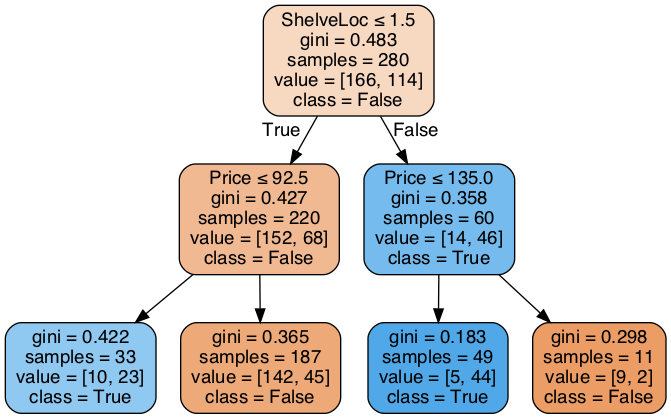

In [65]:
# Create Tree Chart
dot_data = StringIO()

export_graphviz(clf_tree_sales, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns, class_names=['False', 'True'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [50]:
# Calculate test error on test set
y_pred = clf_tree_sales.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
clf_pred_result = pd.DataFrame(matrix, index=['No', 'Yes'], columns=['Pred No', 'Pred Yes'])

# Print result
print('Accuracy: {:.4f}'.format((matrix[0][0]+ matrix[1][1])/(matrix.sum())))
print('')
print(clf_pred_result)
print('')
print(classification_report(y_test, y_pred))

Accuracy: 0.7333

     Pred No  Pred Yes
No        63         7
Yes       25        25

              precision    recall  f1-score   support

           0       0.72      0.90      0.80        70
           1       0.78      0.50      0.61        50

    accuracy                           0.73       120
   macro avg       0.75      0.70      0.70       120
weighted avg       0.74      0.73      0.72       120



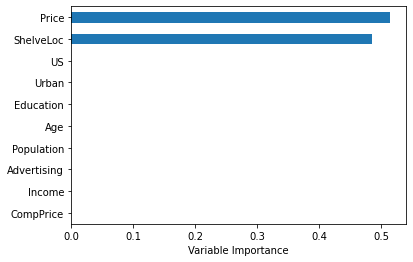

In [51]:
# Create feature importances
feature_importances = pd.DataFrame(clf_tree_sales.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance').plot(kind='barh')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [52]:
# Calculate alphas, impurities effective range
clf_tree = DecisionTreeClassifier(random_state=1)
path = clf_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas_train, impurities_tran = path.ccp_alphas, path.impurities

In [53]:
# Draw Chart alphas vs impurities
def display_clf_tree_pruning_result(ccp_alphas, X_train, X_test, y_train, y_test):

    # Create data
    impurity = []
    leaves_counts = []
    train_accuracy, test_accuracy = [], []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        clf_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=1)
        clf_tree.fit(X_train, y_train)

        # Append result on node counts, r2, mse
        impurity.append(clf_tree.tree_.impurity.mean())
        leaves_counts.append(clf_tree.tree_.n_leaves)
        train_accuracy.append(clf_tree.score(X_train, y_train))
        test_accuracy.append(clf_tree.score(X_test, y_test))

    # Wrap to numpy array to for easy to manipulate
    impurity = np.array(impurity)
    leaves_counts = np.array(leaves_counts)
    train_accuracy = np.array(train_accuracy)
    test_accuracy = np.array(test_accuracy)

    # print(test_r2)

    k = test_accuracy.argmax()
    k_f = k + 5
    k_b = k - 20

    # Start plot data
    plt.figure(figsize=(16,12))

    plot_1 = plt.subplot(221)
    plt.plot(ccp_alphas[:-1], impurity[:-1], marker='o', drawstyle='steps-post')
    plt.xlabel('Alphas')
    plt.ylabel('Impurities of leaves')
    plt.title('Impurities vs Alphas for training set')

    plot_2 = plt.subplot(222)
    plt.plot(ccp_alphas, leaves_counts, drawstyle='steps-post')
    plt.plot(ccp_alphas[k], leaves_counts[k], 'ro', label='At min test MSE, alpha: {:.4f}, number Leaves: {}'.format(ccp_alphas[k], leaves_counts[k]))
    plt.xlabel('Alphas')
    plt.ylabel('Number of Leaves')
    plt.legend()
    plt.title('Number of Leaves vs Alphas for training set')

    plot_3 = plt.subplot(212)
    plt.plot(ccp_alphas, train_accuracy, drawstyle='steps-post', label='train R2')
    plt.plot(ccp_alphas, test_accuracy, drawstyle='steps-post', label='test R2')
    plt.plot(ccp_alphas[k], test_accuracy[k], 'ro', label='Max test Accuracy: {:.4f} at alpha: {:.4f}'.format(test_accuracy[k], ccp_alphas[k]))
    plt.xlabel('Alphas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Alphas on train-test set')

    plt.show()

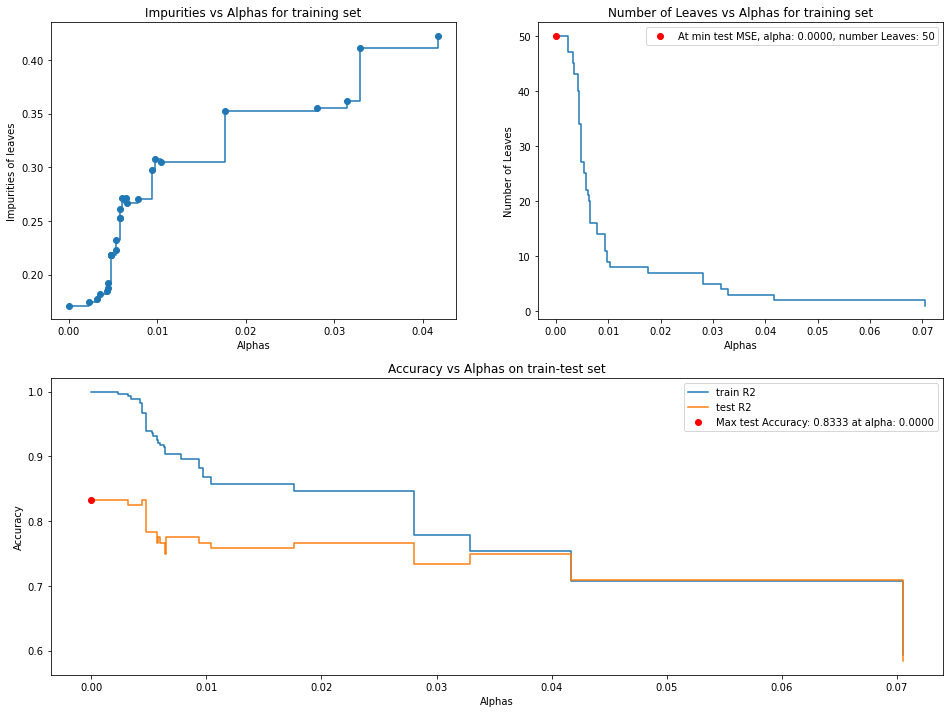

In [54]:
display_clf_tree_pruning_result(ccp_alphas_train, X_train, X_test, y_train, y_test)

In [83]:
# Calculate optimal alpha for Pruning Tree by using Cross-validation
def display_clf_tree_pruning_cv_result(ccp_alphas, X, y):

    cv = KFold(n_splits=10, shuffle=True, random_state=1)

    # Create data
    train_accuracy = []
    test_accuracy = []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        clf_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=1)
        score = cross_validate(clf_tree, X, y, cv=cv, scoring=('accuracy', 'f1'), return_train_score=True)

        # Append result mean accuracy, mse
        train_accuracy.append(np.mean(score['train_accuracy']))
        test_accuracy.append(np.mean(score['test_accuracy']))

    # Wrap to numpy array to for easy to manipulate
    train_accuracy = np.array(train_accuracy)
    test_accuracy = np.array(test_accuracy)

    k = test_accuracy.argmax()
    k_f_bound = len(test_accuracy)-1-k
    k_f = k + k_f_bound
    k_b = k - k

    optimal_clf_tree = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alphas[k]).fit(X, y)
    leaves = optimal_clf_tree.tree_.n_leaves
    # Start plot data
    plt.figure(figsize=(8,6))

    plt.plot(ccp_alphas, train_accuracy, drawstyle='steps-post', label='train Accuracy')
    plt.plot(ccp_alphas, test_accuracy, label='test R2')
    plt.plot(ccp_alphas[k], test_accuracy[k], 'ro', label='Max test Accuracy: {:.4f} at alpha: {:.4f}, {} leaves'.format(test_accuracy[k], ccp_alphas[k], leaves))
    plt.xlabel('Alphas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy on test set')

    plt.show()

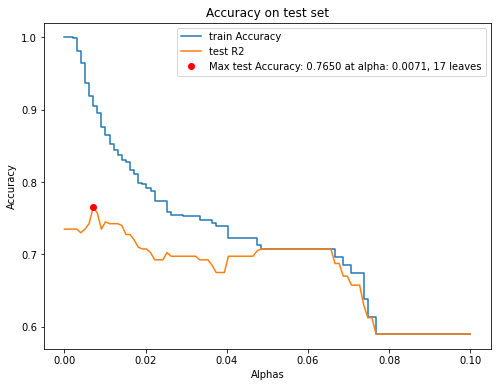

In [84]:
ccp_alphas_cv = np.linspace(0,0.1,100)
display_clf_tree_pruning_cv_result(ccp_alphas_cv, X, y)

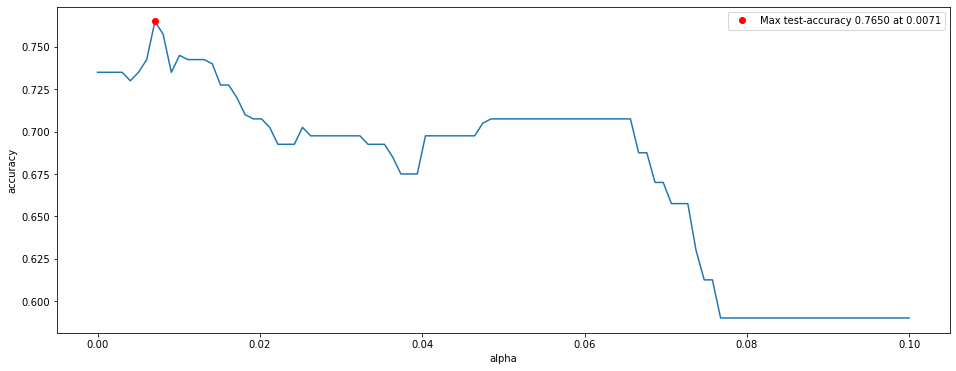

In [69]:
# Pruning the decision tree, use cross-validation to find alpha
cv = KFold(n_splits=10, shuffle=True, random_state=1)
accuracy = []
alphas = ccp_alphas_cv
for a in alphas:
    clf_tree = DecisionTreeClassifier(ccp_alpha=a, random_state=1)
    score = cross_val_score(clf_tree, X, y, cv=cv, scoring='accuracy')
    accuracy.append(np.mean(score))

accuracy = np.array(accuracy)
k = accuracy.argmax()
alpha_optimal = alphas[k]

plt.figure(figsize=(16,6))
plt.plot(alphas, accuracy)
plt.plot(alpha_optimal, accuracy.max(), 'ro', label='Max test-accuracy {:.4f} at {:.4f}'.format(accuracy.max(), alpha_optimal))
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [98]:
# Use Crossvalidation to find optimal max leaves
def display_clf_tree_pruning_cv_result_leaves(leaves_range, X, y):

    cv = KFold(n_splits=10, shuffle=True, random_state=1)

    # Create data
    train_accuracy = []
    test_accuracy = []
    for i in leaves_range:

        # Create a list model due to changes of alpha
        clf_tree = DecisionTreeClassifier(max_leaf_nodes=i, random_state=1)
        score = cross_validate(clf_tree, X, y, cv=cv, scoring=('accuracy', 'f1'), return_train_score=True)

        # Append result mean r2, mse
        train_accuracy.append(np.mean(score['train_accuracy']))
        test_accuracy.append(np.mean(score['test_accuracy']))

    # Wrap to numpy array to for easy to manipulate
    train_accuracy = np.array(train_accuracy)
    test_accuracy = np.array(test_accuracy)

    k = test_accuracy.argmax()

    # Start plot data
    plt.figure(figsize=(16,6))

    plt.plot(leaves_range, train_accuracy, label='train accuracy')
    plt.plot(leaves_range, test_accuracy, label='test accuracy')
    plt.plot(leaves_range[k], test_accuracy[k], 'ro', label='Max test accuracy: {:.4f} at max {} leaves'.format(test_accuracy[k], leaves_range[k]))
    plt.xlabel('Max Leaf nodes')
    plt.ylabel('Accuracy')
    plt.xticks(leaves_range)
    plt.legend()
    plt.title('Accuracy test set')

    plt.show()

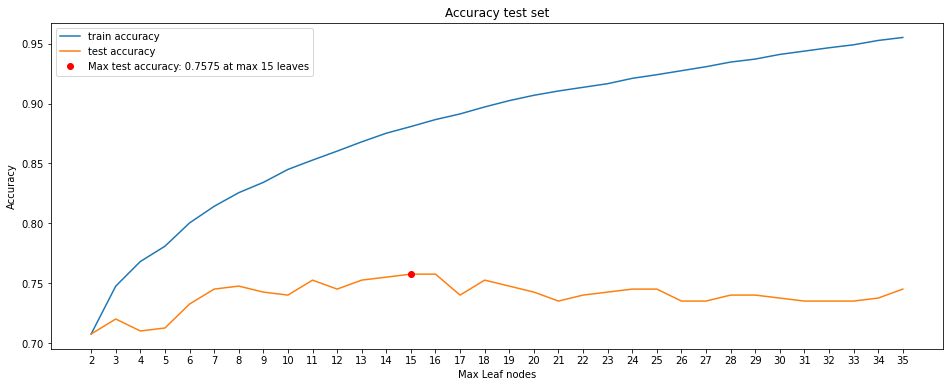

In [99]:
leaves_range = np.arange(2,36)
display_clf_tree_pruning_cv_result_leaves(leaves_range, X, y)

In [105]:
# Create function classification
clf_tree_sales = DecisionTreeClassifier(ccp_alpha=alpha_optimal, random_state=1)
clf_tree_sales.fit(X, y)

# Return training accuracy
print('Accuracy: {:.4f}'.format(clf_tree_sales.score(X, y)))
print(clf_tree_sales.tree_.n_leaves)

Accuracy: 0.8925
17


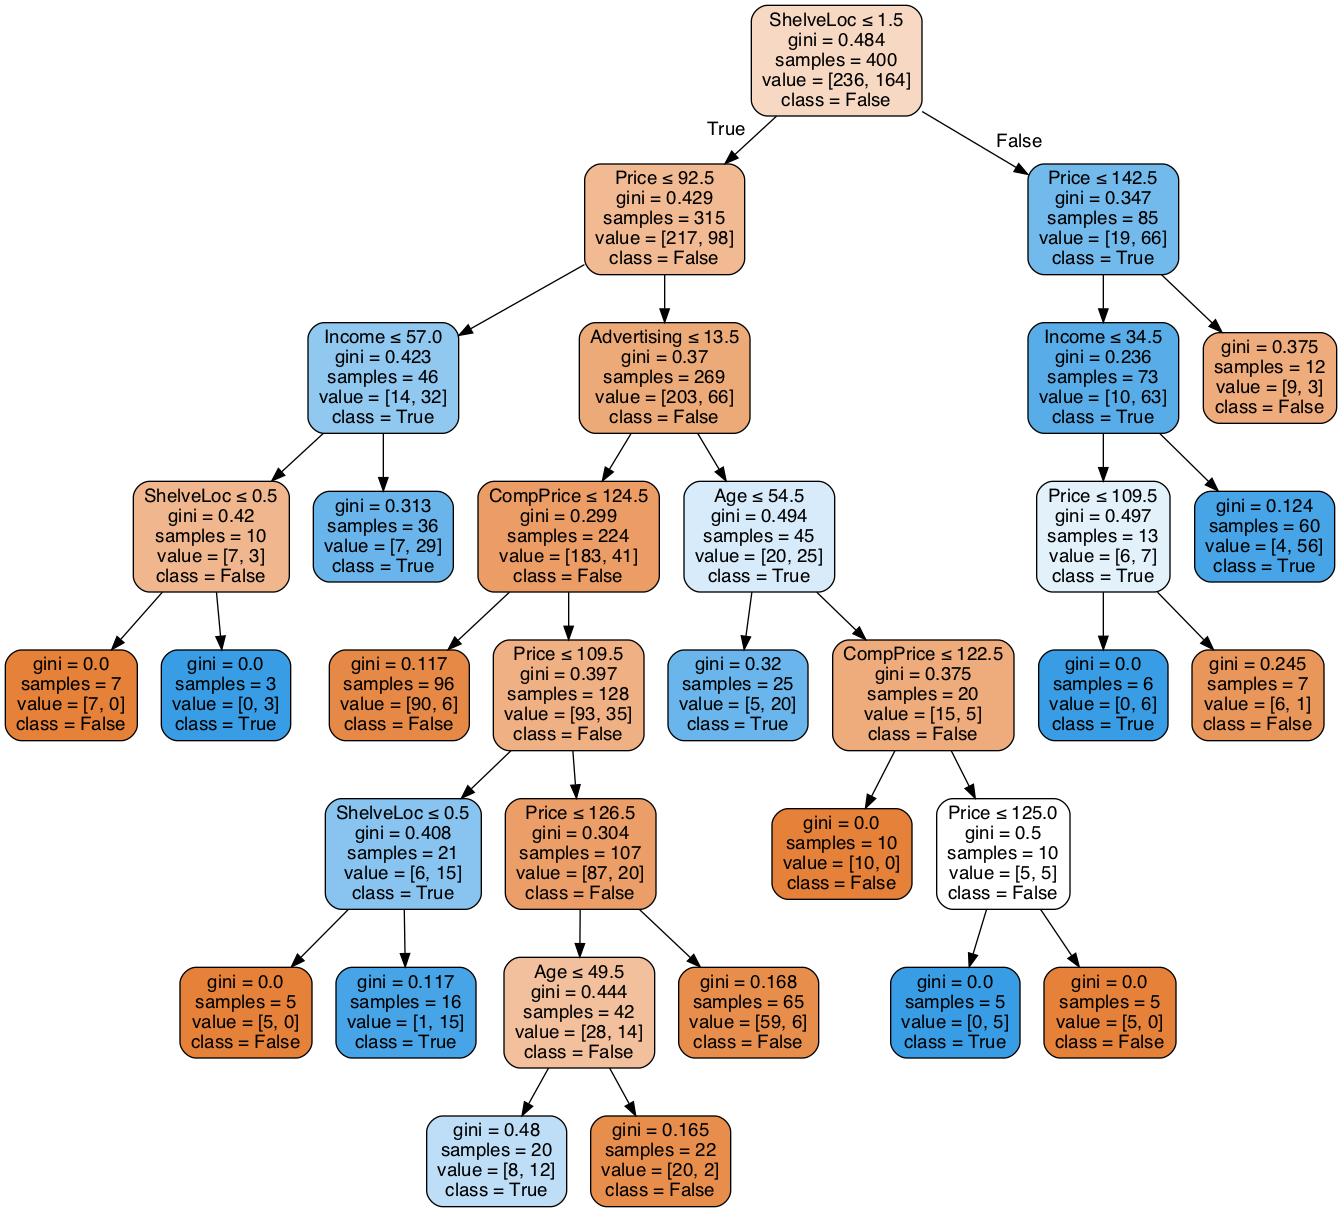

In [106]:
# Create Tree Chart
dot_data = StringIO()

export_graphviz(clf_tree_sales, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns, class_names=['False', 'True'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

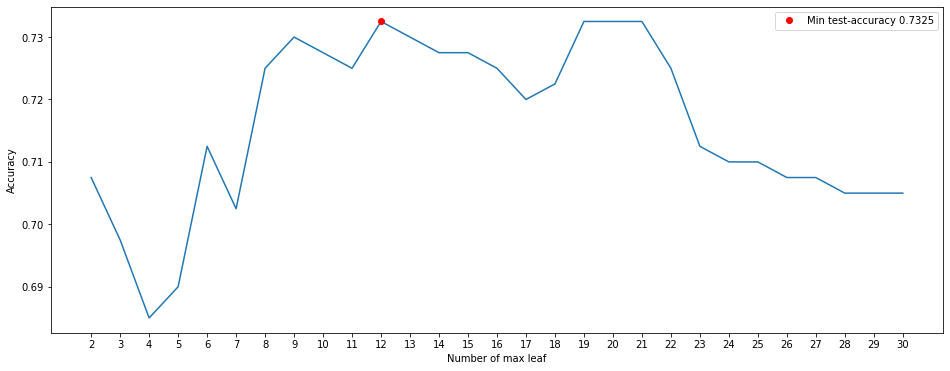

In [104]:
# Pruning the decision tree
cv = KFold(n_splits=10, shuffle=True, random_state=1)
accuracy = pd.Series([])
for i in range(2,31):
    clf_tree = DecisionTreeClassifier(max_leaf_nodes=i, random_state=1)
    score = cross_val_score(clf_tree, X, y, scoring='accuracy')
    accuracy.loc[i] = np.mean(score)

plt.figure(figsize=(16,6))
plt.plot(accuracy.index, accuracy)
plt.plot(accuracy.argmax()+2, accuracy.max(), 'ro', label='Min test-accuracy {:.4f}'.format(accuracy.max()))
plt.xticks(accuracy.index)
plt.xlabel('Number of max leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.show()